# TOP HOTEL OPPORTUNITIES

## **INSTRUÇÕES**

---
### Todos os arquivos baixados devem ser upados na pasta 'Arquivos de entrada'
---

#### **Passo 1:**  Acesse [esse link](https://metabase.hurb-data.com/question/4324-curva-a-trivago) para baixar os dados de performance dos hotéis para os períodos de mês, trimestre e ano. Essa query já está 100% automatizada. Não é necessário realizar edições. Nomeie esse arquivo como:

* query_curva.csv

#### **Passo 2:** Acesse o SFTP do Trivago, vá para a página outfiles e baixe o arquivo **trivago_hotel_data_br.csv** e renomeie ele para:

* feed.csv

#### **Passo 3:** Acesse o SFTP do Trivago, vá para a página outfiles e baixe o arquivo **feed_cpa.csv**. Não é necessário renomeá-lo. Apenas coloque-o na pasta de arquivos de entrada:

* feed_cpa.csv




In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
#@markdown Importando bibliotecas
### importando bibliotecas que iremos utilizar
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Setting the palette
sns.set_palette(sns.color_palette('pastel'))

In [4]:
# Importing dataset
#@markdown Importando dataset

hotels = pd.read_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/Arquivo de entrada/query_curva.csv', encoding = "ISO 8859-1").fillna(0)
feed = pd.read_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/Arquivo de entrada/feed.csv', encoding = "ISO 8859-1")
campaigns = pd.read_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/Arquivo de entrada/feed_cpa.csv', encoding = "ISO 8859-1" )

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
campaigns.head()

,locale,partner_reference,campaign
0,BR,JNP-JP984417,0
1,BR,OMN-142,0
2,BR,OMN-4789,0
3,BR,OMN-4811,0
4,BR,OMN-4814,0


In [6]:
# renaming columns
feed.rename(columns = {'partner_reference':'sku'}, errors = 'raise', inplace = True)
campaigns.rename(columns = {'partner_reference':'sku', 'locale':'pos'}, errors = 'raise', inplace = True)
campaigns.head()

,pos,sku,campaign
0,BR,JNP-JP984417,0
1,BR,OMN-142,0
2,BR,OMN-4789,0
3,BR,OMN-4811,0
4,BR,OMN-4814,0


In [7]:
# subsetting campaigns by pos
campaigns_br = campaigns[campaigns['pos'] == 'BR']
campaigns_us = campaigns[campaigns['pos'] == 'US']

campaigns_br.head()

,pos,sku,campaign
0,BR,JNP-JP984417,0
1,BR,OMN-142,0
2,BR,OMN-4789,0
3,BR,OMN-4811,0
4,BR,OMN-4814,0


In [8]:
#@markdown Exibindo primeiras linhas do dataset
hotels.head() 

,pos,sku,pedidos_mes_atual,pedidos_trimestre_atual,pedidos_ano_atual,pedidos_mes_ano_passado,impr_mes_atual,impr_trimestre_atual,impr_ano_atual,impr_mes_ano_passado,fatop_mes_atual,fatop_trimestre_atual,fatop_ano_atual,fatop_mes_ano_passado,stddev_pedidos_mes_atual,stddev_fatop_mes_atual,stddev_impressions_mes_atual
0,BR,OMN-11037,41.0,49.0,52.0,0.0,7992,18820,21869,0,6399.40,8704.17,9279.07,0.00,0.143673,23.879796,8.676673
1,BR,OMN-3883,33.0,66.0,138.0,29.0,28305,75705,289068,27947,17572.97,32357.67,66707.87,11391.25,0.049269,34.617516,11.982634
2,BR,OMN-6869,31.0,91.0,184.0,4.0,50720,124245,333390,25564,62160.20,166064.37,302106.04,4232.35,0.041663,99.465109,21.808103
3,BR,OMN-4467,31.0,62.0,112.0,54.0,22403,54085,165318,24837,68999.07,125238.46,187336.68,57176.61,0.049614,142.102596,8.853070
4,BR,OMN-6444,30.0,84.0,134.0,10.0,16895,36695,74604,5282,6831.03,23001.48,34694.19,2774.60,0.061400,15.698251,12.282784


In [9]:
#@markdown Exibindo informações do dataset
# Printing info on the dataset
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264371 entries, 0 to 264370
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   pos                           264371 non-null  object 
 1   sku                           264371 non-null  object 
 2   pedidos_mes_atual             264371 non-null  float64
 3   pedidos_trimestre_atual       264371 non-null  float64
 4   pedidos_ano_atual             264371 non-null  float64
 5   pedidos_mes_ano_passado       264371 non-null  float64
 6   impr_mes_atual                264371 non-null  int64  
 7   impr_trimestre_atual          264371 non-null  int64  
 8   impr_ano_atual                264371 non-null  int64  
 9   impr_mes_ano_passado          264371 non-null  int64  
 10  fatop_mes_atual               264371 non-null  float64
 11  fatop_trimestre_atual         264371 non-null  float64
 12  fatop_ano_atual               264371 non-nul

In [10]:
#@markdown Temporário: Removendo colunas de comparação com mesmo mês do ano passado pois esses dados ainda não existem no BD.
# removing same month last year comparison because the database still not support this operation (not enough data) -> Remove this after november 2021.
hotels.drop(['pedidos_mes_ano_passado', 'fatop_mes_ano_passado', 'impr_mes_ano_passado'], axis = 1, inplace = True)

In [11]:
#@markdown Fazendo normalização max-min no dataset 
# Applying max-min normalizing function on the dataset
norm_hotels = hotels.copy()
norm_hotels.iloc[:, 2:] = norm_hotels.iloc[:, 2:].apply(lambda x: x/x.max(), axis = 0)

In [12]:
#@markdown Exibindo primeiras linhas do dataset normalizado
norm_hotels.head()

,pos,sku,pedidos_mes_atual,pedidos_trimestre_atual,pedidos_ano_atual,impr_mes_atual,impr_trimestre_atual,impr_ano_atual,fatop_mes_atual,fatop_trimestre_atual,fatop_ano_atual,stddev_pedidos_mes_atual,stddev_fatop_mes_atual,stddev_impressions_mes_atual
0,BR,OMN-11037,1.000000,0.355072,0.109244,0.042516,0.026192,0.012204,0.046415,0.028907,0.006720,0.203185,0.003723,0.098633
1,BR,OMN-3883,0.804878,0.478261,0.289916,0.150578,0.105358,0.161310,0.127457,0.107461,0.048310,0.069677,0.005397,0.136213
2,BR,OMN-6869,0.756098,0.659420,0.386555,0.269822,0.172911,0.186043,0.450850,0.551503,0.218787,0.058921,0.015508,0.247905
3,BR,OMN-4467,0.756098,0.449275,0.235294,0.119180,0.075270,0.092253,0.500452,0.415920,0.135671,0.070165,0.022156,0.100638
4,BR,OMN-6444,0.731707,0.608696,0.281513,0.089878,0.051068,0.041632,0.049546,0.076388,0.025126,0.086832,0.002448,0.139625


In [13]:
# Subsetting by pos
norm_hotels_BR = norm_hotels[norm_hotels['pos'] == 'BR']
norm_hotels_US = norm_hotels[norm_hotels['pos'] == 'US']

In [14]:
#@markdown Criando funções de score
# Creating the SCORE
def score(frame, performance_col_name = 'performance_score', 
          impression_col_name = 'impression_score' ):
  
  df = frame.copy()

  df[performance_col_name] = 4 * df['pedidos_mes_atual'] + 2 * df['pedidos_trimestre_atual'] + 1 * df['pedidos_ano_atual'] + \
  4 * df['fatop_mes_atual'] + 2 * df['fatop_trimestre_atual'] + 1 * df['fatop_ano_atual'] - 2 * df['stddev_pedidos_mes_atual'] - \
  2 * df['stddev_fatop_mes_atual']

  df[impression_col_name] = 4 * df['impr_mes_atual'] + 2 * df['impr_trimestre_atual'] + \
  1 * df['impr_ano_atual'] - 2 * df['stddev_impressions_mes_atual']
  
  return df




In [15]:
norm_hotels_BR = score(norm_hotels_BR)
norm_hotels_US = score(norm_hotels_US)

In [16]:
#@markdown Exibindo primeiras linhas do dataset com a coluna de score, ordenado pelo score
# Dataset with the new score column
norm_hotels_BR.sort_values(by = 'performance_score', ascending = False).head()

,pos,sku,pedidos_mes_atual,pedidos_trimestre_atual,pedidos_ano_atual,impr_mes_atual,impr_trimestre_atual,impr_ano_atual,fatop_mes_atual,fatop_trimestre_atual,fatop_ano_atual,stddev_pedidos_mes_atual,stddev_fatop_mes_atual,stddev_impressions_mes_atual,performance_score,impression_score
32,BR,OMN-2182,0.365854,0.231884,0.241597,0.034558,0.026702,0.043397,1.000000,0.879793,0.530668,0.050579,0.069407,0.022594,8.219061,0.189844
39,BR,OMN-9164,0.317073,0.304348,0.287815,0.016369,0.012902,0.020706,0.808430,1.000000,0.604492,0.056242,0.057162,0.014106,7.776207,0.083775
2,BR,OMN-6869,0.756098,0.659420,0.386555,0.269822,0.172911,0.186043,0.450850,0.551503,0.218787,0.058921,0.015508,0.247905,7.706121,1.115342
136,BR,OMN-5252,0.195122,0.956522,0.962185,0.281456,0.183002,0.223883,0.180278,0.950596,0.751625,0.029678,0.010692,0.269895,6.948905,1.175921
52,BR,OMN-1895,0.292683,0.391304,0.819328,0.175310,0.106146,0.157371,0.391873,0.862539,1.000000,0.038890,0.020021,0.148286,6.947417,0.774330


In [17]:
#@markdown Definindo a função de resumo do filtro

def score_info(df, threshold = 0.5, score = 'performance_score'):
  # performance values
  max_score = df[score].max()
  min_score = df[score].min()
  mean_score = df[score].mean()
  std_dev_score = df[score].std()
  filtered_hotels = df[df[score] > threshold]
  num_hotels = len(filtered_hotels)
  skus = filtered_hotels['sku']
  

  # print summary
  print('MAX SCORE: {}'.format(max_score))
  print('MIN SCORE: {}'.format(min_score))
  print("AVERAGE SCORE: {}".format(mean_score))
  print("STANDARD DEVIATION: {}".format(std_dev_score))
  print("NUMBER OF FILTERED HOTELS: {}".format(num_hotels))

  # plot filtered hist
  df[df[score] > threshold][score].hist()

  return (max_score, min_score, mean_score, std_dev_score, num_hotels,skus)



BR PERFORMANCE:
MAX SCORE: 8.219060721824135
MIN SCORE: -1.9470637597118359
AVERAGE SCORE: 0.011018303846318673
STANDARD DEVIATION: 0.13287320233847882
NUMBER OF FILTERED HOTELS: 570
-------------------------------------------
BR IMPRESSIONS:
MAX SCORE: 2.265068287970522
MIN SCORE: -1.8326674179248257
AVERAGE SCORE: -0.0004616943256920997
STANDARD DEVIATION: 0.06183883544934349
NUMBER OF FILTERED HOTELS: 301


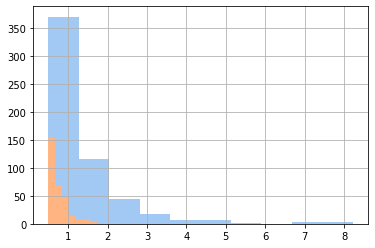

In [18]:
#@markdown Plotando filtro e guardando skus na variavel skus
print('BR PERFORMANCE:')
_, _, _, _, _, skus_BR_performance = score_info(norm_hotels_BR, 0.5, 
                                                score = 'performance_score')

print('-------------------------------------------')
print('BR IMPRESSIONS:')
_, _, _, _, _, skus_BR_impressions = score_info(norm_hotels_BR, 0.5, 
                                                score = 'impression_score')

US PERFORMANCE:
MAX SCORE: 3.6449134531548735
MIN SCORE: -1.402033527824825
AVERAGE SCORE: 0.00031517336750536596
STANDARD DEVIATION: 0.013903734776741793
NUMBER OF FILTERED HOTELS: 204
---------------------------------------------------------------------------
US IMPRESSIONS:
MAX SCORE: 5.779616599355821
MIN SCORE: -0.6475655688287882
AVERAGE SCORE: -0.00020534284774371522
STANDARD DEVIATION: 0.05565427122177485
NUMBER OF FILTERED HOTELS: 186


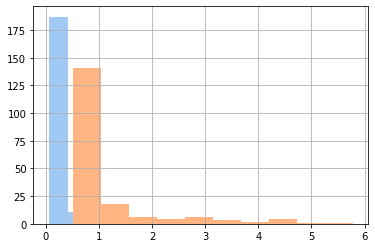

In [19]:
print('US PERFORMANCE:')
_, _, _, _, _, skus_US_performance = score_info(norm_hotels_US, 0.05, 
                                                score = 'performance_score')
print('---------------------------------------------------------------------------')
print('US IMPRESSIONS:')
_, _, _, _, _, skus_US_impressions = score_info(norm_hotels_US, 0.5, 
                                                score = 'impression_score')

# Discovering opportunities

In [20]:
opportunities_br = skus_BR_impressions[~skus_BR_impressions.isin(skus_BR_performance)]
opportunities_us = skus_US_impressions[~skus_US_impressions.isin(skus_US_impressions)]



In [21]:
print("Number of BR TOP IMPRESSION hotels that are not in the TOP PERFORMANCE HOTELS: {}".format(len(opportunities_br)))
print("Number of BR TOP IMPRESSION hotels that are not in the TOP PERFORMANCE HOTELS: {}".format(len(opportunities_us)))

Number of BR TOP IMPRESSION hotels that are not in the TOP PERFORMANCE HOTELS: 157
Number of BR TOP IMPRESSION hotels that are not in the TOP PERFORMANCE HOTELS: 0


In [22]:
### Joining with the feed for some plotting
# Opportunities
opportunities_br_destinations = feed.merge(pd.DataFrame(opportunities_br), on = 'sku')
opportunities_us_destinations = feed.merge(pd.DataFrame(opportunities_us), on = 'sku')

# Top Performers
skus_BR_performance_destinations = feed.merge(pd.DataFrame(skus_BR_performance), on = 'sku')
skus_US_performance_destinations = feed.merge(pd.DataFrame(skus_US_performance), on = 'sku')



In [23]:
def plot_destinations(df, title, col = 'city', xlabel = 'Number of Ocurrences', ylabel = 'Destinations', height = 8, aspect = 1.5):

  try:
    # Defining order of categories. It creates a vector of cities ordered by ocurrences.
    order = df[col].value_counts()[df[col].value_counts() > 2].index 

    # Plot
    g = sns.catplot(y = col, data = df, kind = 'count', 
                    height = height, aspect = aspect, order = order) 

    # Styles
    g.fig.suptitle(title, y = 1.03)
    g.set(xlabel = xlabel, ylabel = ylabel)
    new_list = range(0, df[col].value_counts().max() + 1,2)
    plt.xticks(new_list)

    # Show    
    plt.show()
    
  except Exception as e:
    print('Could not plot the histogram. Error: {}'.format(e))


In [24]:
skus_BR_performance_destinations['city'].value_counts()

Rio De Janeiro            49
Sao Paulo                 25
CancÃºn                   22
ArmaÃ§Ã£o dos BÃºzios     21
Porto Seguro              20
                          ..
Catalao                    1
Canoa Quebrada             1
PLAYA MUJERES              1
SÃ£o Miguel do Gostoso     1
Blumenau                   1
Name: city, Length: 157, dtype: int64

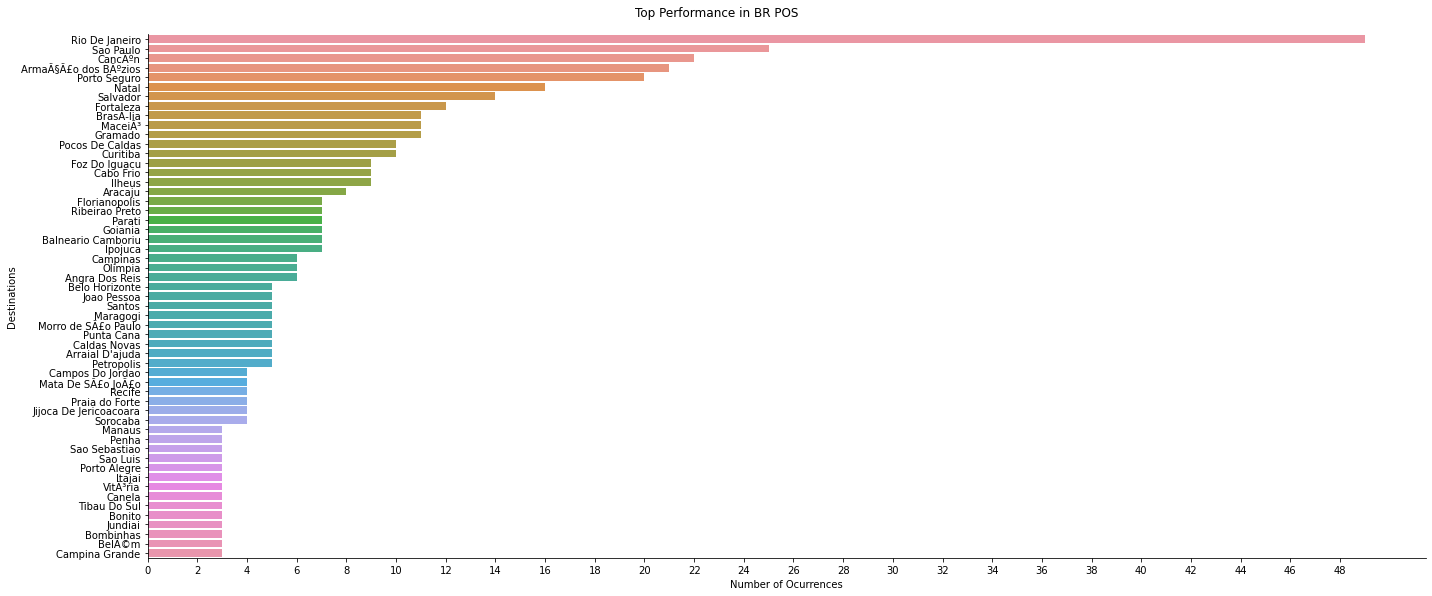

In [25]:
plot_destinations(skus_BR_performance_destinations, 'Top Performance in BR POS', height = 8, aspect = 2.5)

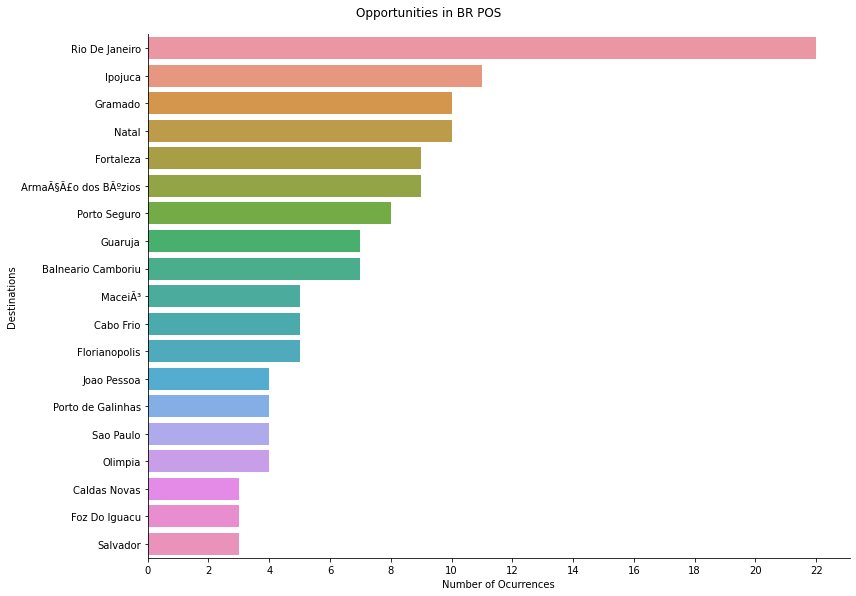

In [26]:
plot_destinations(opportunities_br_destinations, 'Opportunities in BR POS')

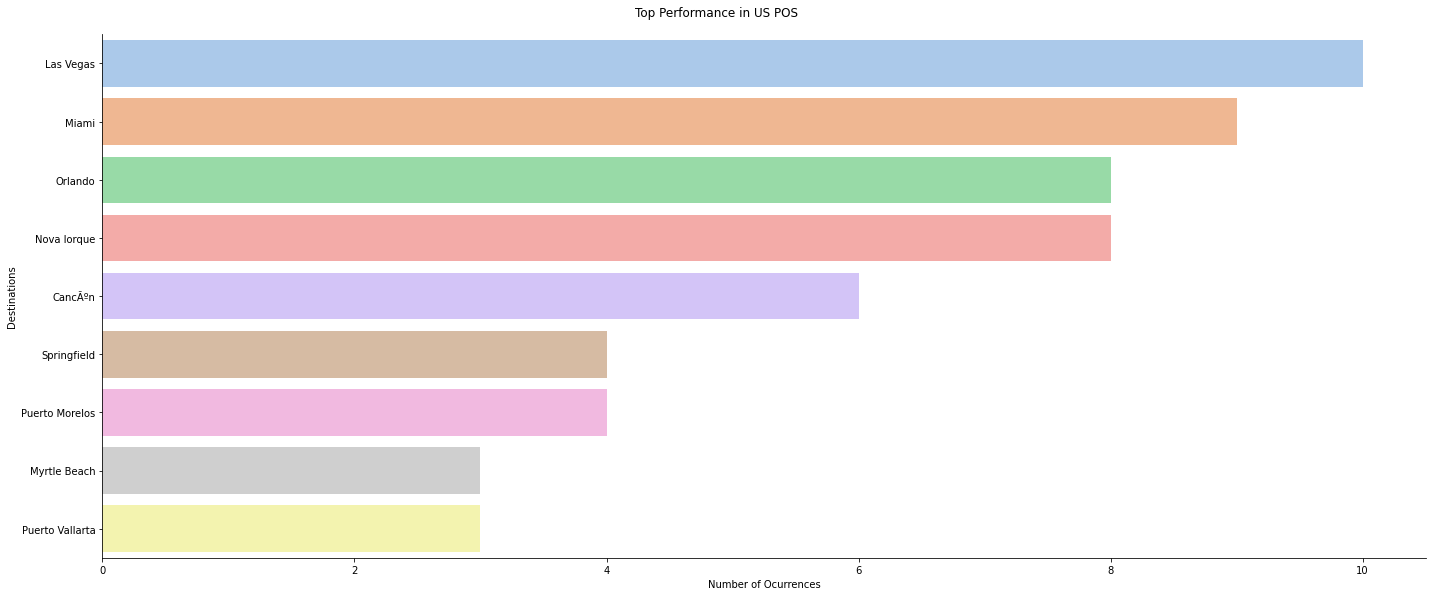

In [27]:
plot_destinations(skus_US_performance_destinations, 'Top Performance in US POS', height = 8, aspect = 2.5)

In [28]:
plot_destinations(opportunities_us_destinations, 'Opportunities in US POS')

Could not plot the histogram. Error: min() arg is an empty sequence


# Campaign Analysis

In [29]:
# Merging with campaign data
skus_BR_performance_destinations_campaigns = pd.merge(skus_BR_performance_destinations, campaigns_br, on = 'sku').drop_duplicates()
opportunities_br_destinations_campaigns = pd.merge(opportunities_br_destinations, campaigns_br, on = 'sku').drop_duplicates()
skus_US_performance_destinations_campaigns = pd.merge(skus_US_performance_destinations, campaigns_us, on = 'sku').drop_duplicates()
opportunities_us_destinations_campaigns = pd.merge(opportunities_us_destinations, campaigns_us, on = 'sku').drop_duplicates()


In [30]:
# Creating count table for campaigns
opportunities_br_campaign_summary = pd.DataFrame(opportunities_br_destinations_campaigns['campaign'].value_counts().rename({0:'CPC', 1:'CPA1', 2:'CPA2'}))
opportunities_us_campaign_summary = pd.DataFrame(opportunities_us_destinations_campaigns['campaign'].value_counts().rename({0:'CPC', 1:'CPA1'}))
performance_br_campaign_summary = pd.DataFrame(skus_BR_performance_destinations_campaigns['campaign'].value_counts().rename({0:'CPC', 1:'CPA1', 2:'CPA2'}))
performance_us_campaign_summary = pd.DataFrame(skus_US_performance_destinations_campaigns['campaign'].value_counts().rename({0:'CPC', 1:'CPA1'}))

In [31]:
print('BR TOP PERFORMANCE HOTELS CAMPAIGNS: ')
performance_br_campaign_summary


BR TOP PERFORMANCE HOTELS CAMPAIGNS: 


,campaign
CPC,419
CPA2,77
CPA1,68


In [32]:
print('BR HOTEL OPPORTUNITIES CAMPAIGN DISTRIBUTION: ')
opportunities_br_campaign_summary

BR HOTEL OPPORTUNITIES CAMPAIGN DISTRIBUTION: 


,campaign
CPC,72
CPA1,54
CPA2,31


In [33]:
print('US TOP PERFORMANCE HOTEL CAMPAIGNS')
performance_us_campaign_summary

US TOP PERFORMANCE HOTEL CAMPAIGNS


,campaign
CPA1,178
CPC,25


In [34]:
print('US HOTEL OPPORTUNITIES CAMPAIGN DISTRIBUTION')
opportunities_us_campaign_summary

US HOTEL OPPORTUNITIES CAMPAIGN DISTRIBUTION


,campaign


In [35]:
### Creating function for plotting distribution of campaigns

def plot_campaigns(df, title, col = 'campaign', xlabel = 'campaigns', ylabel = 'Number of Occurences'):
  try:
    g = sns.catplot(data = df.reset_index(), x = 'index', y = 'campaign', kind= 'bar')
    g.fig.suptitle(title, y = 1.03)
    g.set(xlabel = xlabel, ylabel = ylabel)
    plt.show()
  except Exception as e:
    print('Could not draw plot. Error: {}'.format(e))

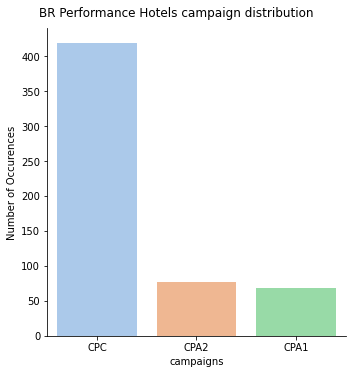

In [36]:
plot_campaigns(performance_br_campaign_summary, 'BR Performance Hotels campaign distribution')

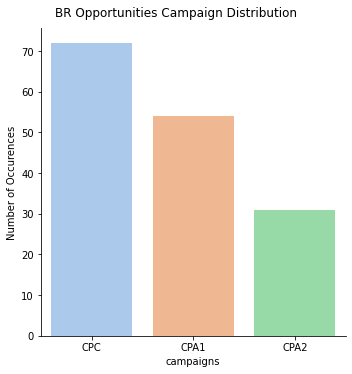

In [37]:
plot_campaigns(opportunities_br_campaign_summary,title = 'BR Opportunities Campaign Distribution', col = 'campaign')

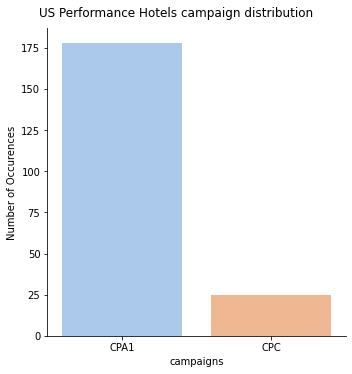

In [38]:
plot_campaigns(performance_us_campaign_summary, 'US Performance Hotels campaign distribution')

In [39]:
plot_campaigns(opportunities_us_campaign_summary,title = 'US Opportunities Campaign Distribution', col = 'campaign')

Could not draw plot. Error: min() arg is an empty sequence


# Outputs

In [40]:
# OUTPUTS

dia = dt.datetime.today().strftime(format='%d.%m.%Y')

# Top performers -> push better deals with hotel owners
skus_BR_performance.to_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/curva A hoteis/top_performance_BR_' + dia + '.csv', index = False)
skus_US_performance.to_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/curva A hoteis/top_performance_US_' + dia + '.csv', index = False)

# Opportunities -> Hotels with plenty of impressions, but that are not among the top performers.
opportunities_br.to_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/curva A hoteis/BR_opportunities_' + dia + '.csv', index = False)
opportunities_us.to_csv('/gdrive/My Drive/Planilha de Bids trivago/Fase 2/curva A hoteis/US_opportunities_' + dia + '.csv', index = False)

